In [2]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
import numpy as np

launch.json used to generate epoch-wise pkls

In [3]:
# {
#     "version": "0.2.0",
#     "configurations": [
#    	 {
#    		 "name": "Run with argument",
#    		 "type": "python",
#    		 "request": "launch",
#    		 "program": "${file}",
#    		 "console": "integratedTerminal",
#    		 "cwd": "${workspaceFolder}/tools",
#    		 "env": {"CUDA_VISIBLE_DEVICES": "1"},
#    		 "args": ["--cfg_file" ,
#            		 "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
#            		 "--split",
#            		 "train_0.01_1",
#            		 "--batch_size",
#            		 "8",
#            		 "--ckpt_save_interval",
#            		 "20",
#            		 "--repeat",
#            		 "5",
#            		 "--fix_random_seed",
#            		 "--extra_tag",
#            		 "tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader",
#            		 "--dbinfos",
#            		 "kitti_dbinfos_train_0.01_1_37.pkl",
#                  "--epochs", // for repeat 5, bsz 8: to cover 3769 ulb frames needs ~21 epochs
#                  "100",
#                  "--ckpt",
#                  "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/ckpts_3diou_split_1_1_0fbd0d1/ckpt/checkpoint_epoch_60.pth",
#                 "--set",
#                  "MODEL.STORE_SCORES_IN_PKL",
#                 "True"
#    		 ],
#    	 }
#     ]
# }


Script to read epoch wise pkls, combine and store as snapshot_pl_data


In [4]:
# import numpy as np
# import matplotlib.pyplot as plt

# def calculate_precision_recall(sorted_y, sorted_assigned_labels, class_id):
#     true_positives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == 1))
#     false_positives = np.sum((sorted_y != class_id) & (sorted_assigned_labels == 0))
#     false_negatives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == -1))

#     precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
#     recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

#     return precision, recall

# comparison_result = np.array(comparison_result)
# precision_car, recall_car = calculate_precision_recall(sorted_y, comparison_result, class_id=0)
# precision_pedestrian, recall_pedestrian = calculate_precision_recall(sorted_y, comparison_result, class_id=1)
# precision_cyclist, recall_cyclist = calculate_precision_recall(sorted_y, comparison_result, class_id=2)

# print("Precision and Recall for Car class:")
# print("Precision:", precision_car)
# print("Recall:", recall_car)

# print("\nPrecision and Recall for Pedestrian class:")
# print("Precision:", precision_pedestrian)
# print("Recall:", recall_pedestrian)

# print("\nPrecision and Recall for Cyclist class:")
# print("Precision:", precision_cyclist)
# print("Recall:", recall_cyclist)


# # plt.figure(figsize=(8, 6))
# # plt.plot(recall_car, precision_car, marker='o', linestyle='-', label='Car')
# # plt.plot(recall_pedestrian, precision_pedestrian, marker='o', linestyle='-', label='Pedestrian')
# # plt.plot(recall_cyclist, precision_cyclist, marker='o', linestyle='-', label='Cyclist')

# # plt.xlabel('Recall')
# # plt.ylabel('Precision')
# # plt.title('Precision-Recall Curve')
# # plt.legend()
# # plt.grid(True)
# # plt.show()


In [5]:
import os
import pickle
import torch
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/kitti_models/pv_rcnn_ssl_60/new_main_3diou_ckpt_36221f4_PLs_20_eps_dda7b2b"
# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_pl_data_20 = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_pl_data_20:
            snapshot_pl_data_20[key] = []
        snapshot_pl_data_20[key].extend(value)

snapshot_pl_data_20['unique_gt_inds_over_thresh'] = snapshot_pl_data_20['gt_inds_over_thresh']


In [6]:
snapshot_pl_data_20.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'iou_values', 'pl_conf_scores', 'roi_scores', 'num_points_in_roi', 'pl_sem_scores', 'iteration', 'shared_features', 'frame_id', 'shared_features_gt', 'pl_uids', 'labeled_mask', 'unlabeled_mask', 'pl_boxes', 'ori_gt_boxes', 'iou_assigned_label', 'gt_classes', 'gt_inds_over_thresh', 'pl_labels', 'pred_scores', 'class_labels', 'unique_gt_inds_over_thresh'])

In [7]:
for i in range(len(snapshot_pl_data_20['gt_inds_over_thresh'])) :
    snapshot_pl_data_20['unique_gt_inds_over_thresh'][i] = torch.unique(snapshot_pl_data_20['gt_inds_over_thresh'][i])

In [8]:
gts_for_recall = []
for idxs, gt_classes in zip(snapshot_pl_data_20['unique_gt_inds_over_thresh'],snapshot_pl_data_20['gt_classes']):
    # Use torch.index_select to efficiently gather GT classes
    selected_classes = torch.index_select(gt_classes, 0, idxs)
    # indices = torch.where(assigned_iou_flag != -1)[0]
    # selected_classes =  selected_classes[indices]
    # print(selected_classes)
    gts_for_recall.append(selected_classes)
gts_for_recall = np.concatenate(gts_for_recall)

In [9]:
len(snapshot_pl_data_20['pl_uids'])

3521

In [10]:
sh_gt_array = np.concatenate(snapshot_pl_data_20['shared_features_gt'])
sh_gt_array.shape
pl_labels = np.concatenate(snapshot_pl_data_20['pl_labels'])
for i in range(len(snapshot_pl_data_20['iou_assigned_label'])):
    snapshot_pl_data_20['iou_assigned_label'][i] = snapshot_pl_data_20['iou_assigned_label'][i].cpu()

iou_assigned_label = np.concatenate(snapshot_pl_data_20['iou_assigned_label'])
iou_assigned_label.shape
pl_boxes = np.concatenate(snapshot_pl_data_20['pl_boxes'])
gt_boxes = np.concatenate(snapshot_pl_data_20['ori_gt_boxes'])
gt_classes = np.concatenate(snapshot_pl_data_20['gt_classes'])
frames =  np.array(snapshot_pl_data_20['frame_id'])
iou_values = np.concatenate(snapshot_pl_data_20['iou_values'])
pl_uids = np.concatenate(snapshot_pl_data_20['pl_uids'])
np.unique(frames).shape
print(pl_boxes.shape, gt_boxes.shape)
print(np.unique(frames).shape)
print(gt_classes.shape)
print(gts_for_recall.shape)
print(iou_values.shape)
print(pl_uids.shape)
print(pl_labels.shape)

(13511, 8) (16818, 8)
(2246,)
(16818,)
(9148,)
(13511,)
(13511,)
(13511,)


In [11]:
PL_all_precision  = (iou_assigned_label > -1).sum() / iou_assigned_label.shape[0]
PL_car_precision = ((iou_assigned_label==0).astype(int) * (pl_labels.astype(int)==0)).sum() / (pl_labels==0).sum()
PL_ped_precision = ((iou_assigned_label==1).astype(int) * (pl_labels.astype(int)==1)).sum() / (pl_labels==1).sum()
PL_cyc_precision =((iou_assigned_label==2).astype(int) * (pl_labels.astype(int)==2)).sum() / (pl_labels==2).sum()

print("Precision FG/BG all PLs:",PL_all_precision )
print("Precision FG/BG for Car PLs:", PL_car_precision)
print("Precision FG/BG for Pedestrian PLs:", PL_ped_precision)
print("Precision FG/BG for for Cyclist PLs:", PL_cyc_precision)



Precision FG/BG all PLs: 0.6770779364961883
Precision FG/BG for Car PLs: 0.7206524645690346
Precision FG/BG for Pedestrian PLs: 0.4064665127020785
Precision FG/BG for for Cyclist PLs: 0.6410714285714286


In [12]:
PL_all_recall  = gts_for_recall.shape[0] / gt_classes.shape[0]
PL_car_recall = (gts_for_recall==0).sum() / ( gt_classes==0).sum()
PL_ped_recall = (gts_for_recall==1).sum() / ( gt_classes==1).sum()
PL_cyc_recall =(gts_for_recall==2).sum() / ( gt_classes==2).sum()

print("Recall FG/BG all GTs:",PL_all_recall)
print("Recall FG/BG for Car GTs:", PL_car_recall)
print("Recall FG/BG for Pedestrian GTs:", PL_ped_recall)
print("Recall FG/BG for for Cyclist GTs:", PL_cyc_recall)


Recall FG/BG all GTs: 0.5439410155785468
Recall FG/BG for Car GTs: 0.572105859043306
Recall FG/BG for Pedestrian GTs: 0.3544813695871098
Recall FG/BG for for Cyclist GTs: 0.5128571428571429


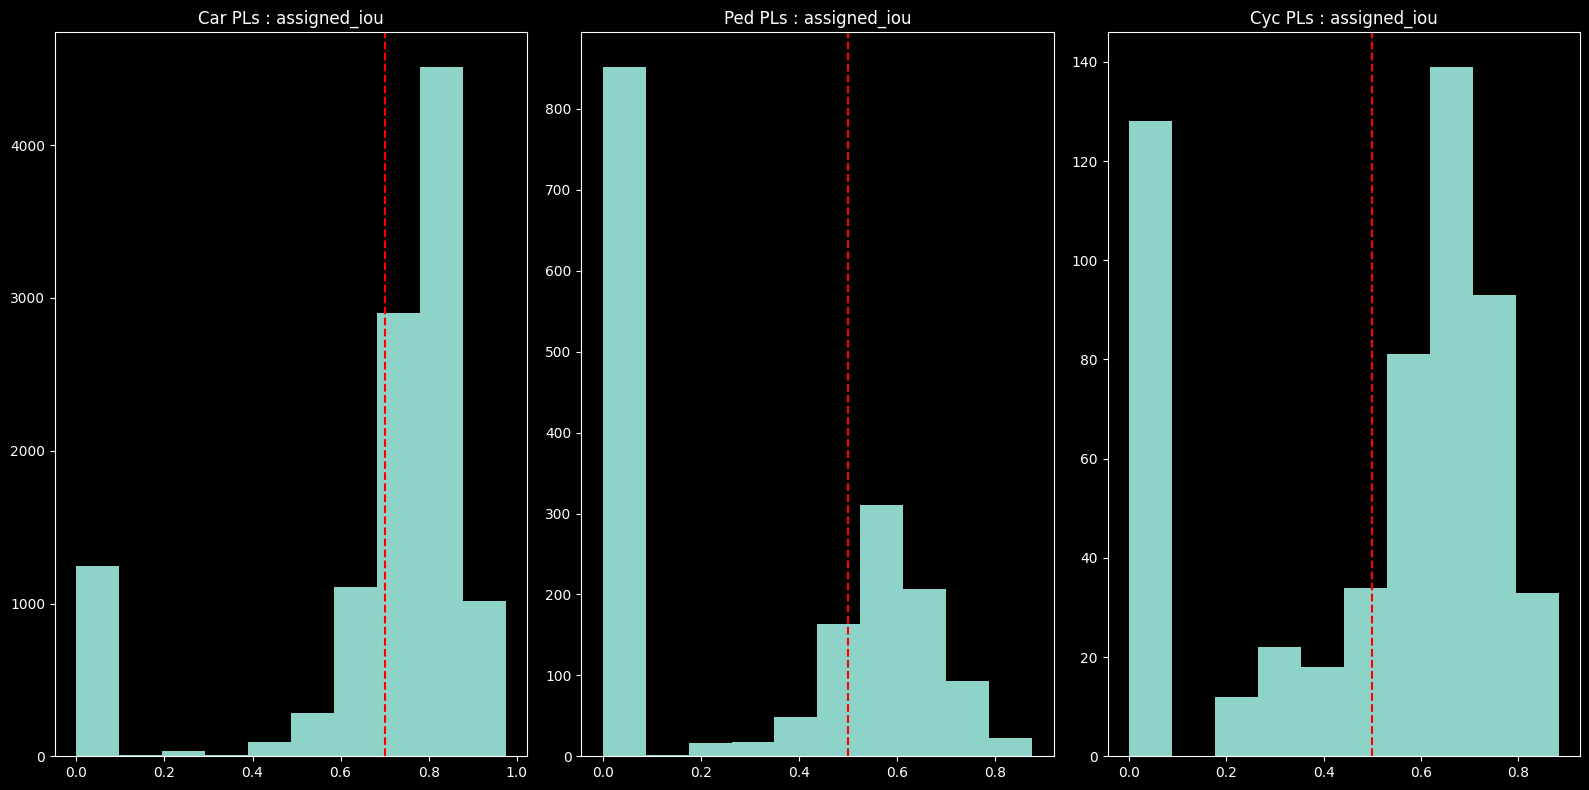

In [13]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 3, figsize=(16, 8))  # Create a figure with 3 subplots side by side
for ax in axs:
    ax.grid(False)
# Plot the first scatter plot in the first subplot
axs[0].hist(iou_values[pl_labels ==0])
axs[0].set_title('Car PLs : assigned_iou',fontsize = 12)
axs[0].axvline(x=0.7, color='red', linestyle='--')
# Plot the second scatter plot in the second subplot
axs[1].hist(iou_values[pl_labels ==1])
axs[1].set_title('Ped PLs : assigned_iou',fontsize = 12)
axs[1].axvline(x=0.5, color='red', linestyle='--')
# Plot the third scatter plot in the third subplot
axs[2].hist(iou_values[pl_labels ==2])
axs[2].set_title('Cyc PLs : assigned_iou', fontsize = 12)
axs[2].axvline(x=0.5, color='red', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

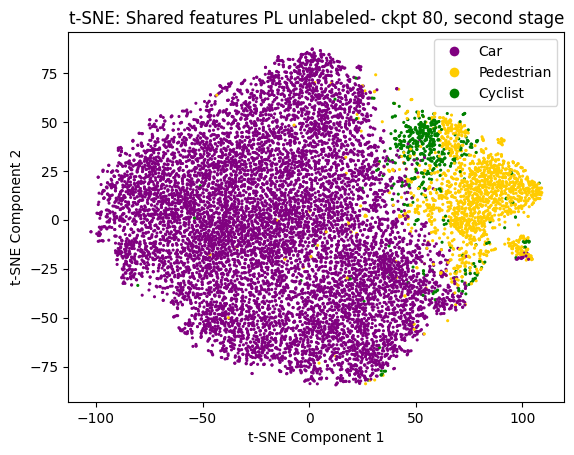

In [14]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_asgns= iou_assigned_label
pl_uids =  pl_uids
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
cmap = ListedColormap(colors)
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

legend_labels = ['Car', 'Pedestrian', 'Cyclist']
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
plt.legend(handles=handles, labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()

In [15]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_asgns = iou_assigned_label
pl_uids = pl_uids

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Define custom colors for each class
colors = ['purple', 'rgba(255, 204, 0, 0.8)', 'green']  # Using a slightly transparent darker yellow

# Create trace for scatter plot
scatter = go.Scatter(
    x=x_tsne[:, 0],
    y=x_tsne[:, 1],
    mode='markers',
    marker=dict(
        color=y,
        colorscale=colors,  # Set custom colorscale
        size=5
    ),
    hoverinfo='text',
    text=pl_uids  # PL_Uid values for hover text
)

# Create layout
layout = go.Layout(
    title='t-SNE: Shared features PL unlabeled - ckpt 80, second stage',
    xaxis=dict(title='t-SNE Component 1'),
    yaxis=dict(title='t-SNE Component 2'),
)

# Create figure
fig = go.Figure(data=[scatter], layout=layout)

# Show plot
fig.show()


In [16]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x = sh_gt_array
# y = pl_labels.astype(int)
# x_normalized = scaler.fit_transform(x)
iou_asgns = iou_assigned_label
# marker_dict = {0:"s",1:"o",2:"d"}
# markers = [marker_dict[y[i]] for i in range(len(y))]
# # Perform t-SNE on normalized features
# tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
# x_tsne = tsne.fit_transform(x_normalized)

sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_iou_asgns = iou_asgns[sorted_indices]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(sorted_y, sorted_iou_asgns)]

colors = [(1,0,0,0.9) if result == -1 else ((0,0,0,0) if result == 1 else (0,0,0,0)) for result in comparison_result]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1


In [17]:
# Get indices where comparison_result is -1
indices_result_minus_1 = [i for i, result in enumerate(comparison_result) if result == -1]

# Filter arrays based on these indices
filtered_sorted_x_tsne = sorted_x_tsne[indices_result_minus_1]
filtered_sorted_y = sorted_y[indices_result_minus_1]
filtered_sorted_iou_asgn = sorted_iou_asgns[indices_result_minus_1]
filtered_colors = [colors[i] for i in indices_result_minus_1]
filtered_pl_uids = pl_uids[indices_result_minus_1]

indices_result_plus_1 = [i for i, result in enumerate(comparison_result) if result == 1]

# Filter arrays based on these indices
plus_filtered_sorted_x_tsne = sorted_x_tsne[indices_result_plus_1]
plus_filtered_sorted_y = sorted_y[indices_result_plus_1]
plus_filtered_sorted_iou_asgn = sorted_iou_asgns[indices_result_plus_1]
plus_filtered_colors = [colors[i] for i in indices_result_plus_1]
plus_filtered_pl_uids =  pl_uids[indices_result_plus_1]

In [18]:
minus_idx_0_last = np.where(filtered_sorted_y == 0)[0][-1]
minus_idx_1_first = np.where(filtered_sorted_y == 1)[0][0]
minus_idx_1_last = np.where(filtered_sorted_y == 1)[0][-1]+1

plus_idx_0_last = np.where(plus_filtered_sorted_y == 0)[0][-1]
plus_idx_1_first = np.where(plus_filtered_sorted_y == 1)[0][0]
plus_idx_1_last = np.where(plus_filtered_sorted_y == 1)[0][-1]+1

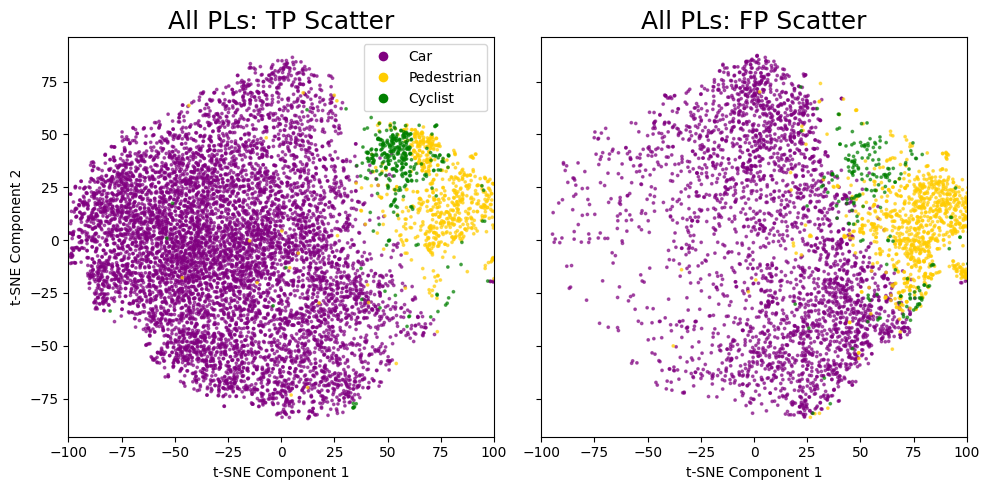

In [19]:
# colors = ['purple', 'yellow', 'green']

darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
cmap = ListedColormap(colors)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5), sharey=True)
ax1.scatter(plus_filtered_sorted_x_tsne[:, 0], plus_filtered_sorted_x_tsne[:, 1], c=plus_filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_title('All PLs: TP Scatter', fontsize=18)
# ax1.legend(handles=scatter.legend_elements()[0], labels=legend_labels)  
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
ax1.legend(handles, legend_labels)
# Plot second subplot
ax2.scatter(filtered_sorted_x_tsne[:, 0], filtered_sorted_x_tsne[:, 1], c=filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_title('All PLs: FP Scatter', fontsize=18)
# ax2.legend(handles=scatter.legend_elements(), labels = legend_labels)


for ax in [ax1, ax2]:
    ax.set_xlim(-100, 100)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import webbrowser

# Define the colors and colormap
darker_yellow = 'rgba(255, 204, 0, 0.8)'  # RGBA values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
legend_labels = ['Car', 'Pedestrian', 'Cyclist']

# Create traces for each subplot
trace1 = go.Scatter(
    y = plus_filtered_sorted_x_tsne[:, 0],
    x = plus_filtered_sorted_x_tsne[:, 1],
    mode='markers',
    marker=dict(color = plus_filtered_sorted_y, colorscale=colors, size=3, opacity=0.6),
    name='All PLs: TP Scatter',
    hoverinfo='text',
    text=plus_filtered_pl_uids )

trace2 = go.Scatter(
    y = filtered_sorted_x_tsne[:, 0],
    x = filtered_sorted_x_tsne[:, 1],
    mode='markers',
    marker=dict(color = filtered_sorted_y, colorscale=colors, size=3, opacity=0.6),
    name='All PLs: FP Scatter',
    hoverinfo='text',
    text=filtered_pl_uids  
)

# Create subplot layout
fig = make_subplots(rows=1, cols=2, subplot_titles=('All PLs: TP Scatter', 'All PLs: FP Scatter'))

# Add traces to the subplot
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)

# Update layout
fig.update_layout(
    title='t-SNE: All PLs TP & FP Scatter',
    xaxis=dict(title='t-SNE Component 1'),
    yaxis=dict(title='t-SNE Component 2'),
    showlegend=True,
    legend=dict(x=0.02, y=0.98, bgcolor='rgba(255,255,255,0.6)'),
    hovermode='closest',
    width=1000,  # Adjust width to accommodate both subplots
)

# Show plot
fig.show()
html_file = "Tsne_TP_FP_plot.html"
pio.write_html(fig, html_file,include_plotlyjs=True,default_height='50%', default_width='75%')
webbrowser.open(html_file)

True

In [21]:
# # colors = ['purple', 'yellow', 'green']

# darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
# colors = ['purple', darker_yellow, 'green']
# cmap = ListedColormap(colors)


# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5), sharey=True)
# ax1.scatter(plus_filtered_sorted_x_tsne[:, 0], plus_filtered_sorted_x_tsne[:, 1], c=plus_filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
# ax1.set_xlabel('t-SNE Component 1')
# ax1.set_ylabel('t-SNE Component 2')
# ax1.set_title('All PLs: TP Scatter', fontsize=18)
# # ax1.legend(handles=scatter.legend_elements()[0], labels=legend_labels)  
# legend_labels = ['Car', 'Pedestrian', 'Cyclist']
# handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
# ax1.legend(handles, legend_labels)
# # Plot second subplot
# ax2.scatter(filtered_sorted_x_tsne[:, 0], filtered_sorted_x_tsne[:, 1], c=filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
# ax2.set_xlabel('t-SNE Component 1')
# ax2.set_title('All PLs: FP Scatter', fontsize=18)
# # ax2.legend(handles=scatter.legend_elements(), labels = legend_labels)


# for ax in [ax1, ax2]:
#     ax.set_xlim(-100, 100)
# plt.tight_layout()  # Adjust layout to prevent overlapping
# plt.show()



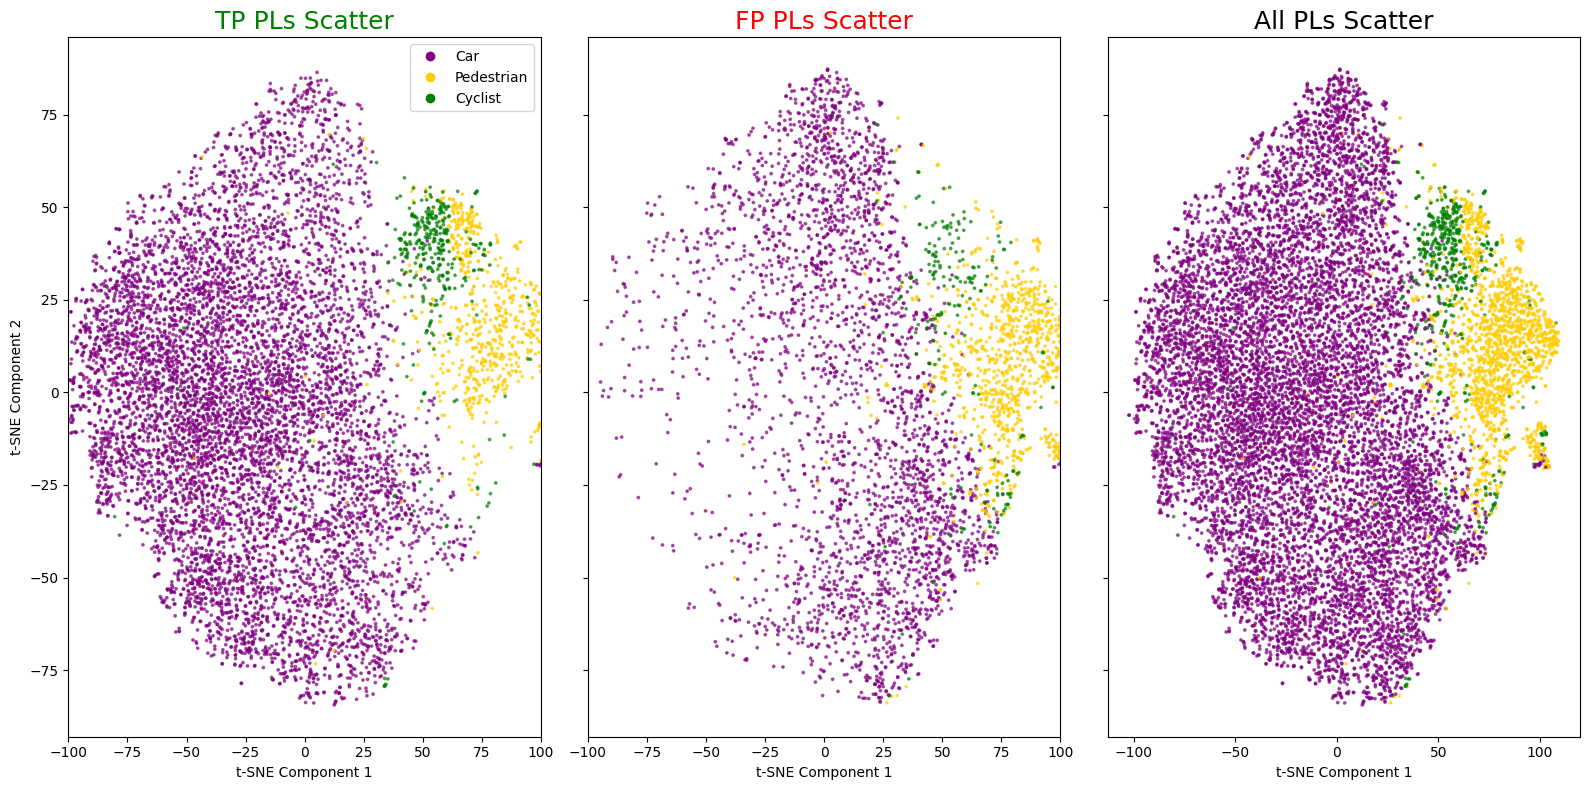

In [22]:
# colors = ['purple', 'yellow', 'green']

darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
cmap = ListedColormap(colors)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8),sharey=True)
ax1.scatter(plus_filtered_sorted_x_tsne[:, 0], plus_filtered_sorted_x_tsne[:, 1], c=plus_filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_title('TP PLs Scatter', fontsize=18, color='green')
# ax1.legend(handles=scatter.legend_elements()[0], labels=legend_labels)  
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
ax1.legend(handles, legend_labels)
# Plot second subplot
ax2.scatter(filtered_sorted_x_tsne[:, 0], filtered_sorted_x_tsne[:, 1], c=filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_title('FP PLs Scatter', fontsize=18, color='red')
# ax2.legend(handles=scatter.legend_elements(), labels = legend_labels)
ax3.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap = cmap, s=3, alpha=0.6)
ax3.set_xlabel('t-SNE Component 1')
ax3.set_title('All PLs Scatter', fontsize=18, color='black')

for ax in [ax1, ax2]:
    ax.set_xlim(-100, 100)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
